In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import warnings
import os

warnings.filterwarnings("ignore")
results_dir = "./resluts"
os.makedirs(results_dir, exist_ok=True)


## (A) Generate synthetic data.

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

Without shuffling, X horizontally stacks features in the following order: the primary n_informative features, followed by n_redundant linear combinations of the informative features, followed by n_repeated duplicates, drawn randomly with replacement from the informative and redundant features. The remaining features are filled with random noise. Thus, without shuffling, all useful features are contained in the columns X[:, :n_informative + n_redundant + n_repeated].

In [45]:
n_samples = 1000
n_features = 20
n_informative = 5
n_redundant = 0
n_repeated = 0
n_classes = 2
def make_dataset(): 


    X, y = make_classification(
        n_samples=n_samples, 
        n_features=n_features, 
        n_informative=n_informative, 
        n_redundant=n_redundant, 
        n_repeated=n_repeated, 
        n_classes=n_classes, 
        shuffle=False
        )
    X = pd.DataFrame(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    X_all = np.vstack((X_train, X_test))
    return X_train, X_test, y_train, y_test, X_all
X_train, X_test, y_train, y_test, X_all = make_dataset()
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
651,-0.995245,0.345919,-0.137296,0.544553,-0.056062,0.849653,0.695664,-1.732796,0.839865,0.543453,-0.245135,-0.197694,0.120162,0.187157,0.789636,-1.483165,-0.603131,-2.218175,-0.885215,0.734209
129,-1.507083,0.226334,-0.731457,-1.196505,2.170605,0.997209,-1.625728,1.039568,-0.131980,-0.803911,2.235673,0.300991,0.471529,-0.711130,1.664473,0.873415,0.098442,-0.869634,-0.843124,1.114923
282,0.072638,1.489878,-1.096651,0.511822,-0.323705,-0.904039,-1.101754,-1.709483,-0.164564,1.059580,1.220024,-0.823169,-0.143593,1.987558,-0.435977,1.251579,-0.423267,-1.137803,0.936248,0.235200
739,0.465442,-1.120794,1.491307,1.236943,0.046554,0.236776,1.458169,-0.621940,-0.794418,-0.694388,-0.318793,0.135371,-1.194865,-0.927320,0.754939,-1.611848,-0.275997,2.534248,0.463358,0.993345
488,1.738890,-2.065209,-1.115760,-1.538136,2.406132,-1.563466,0.712726,-0.030555,-0.714694,0.131832,-0.717690,1.439045,-0.191004,2.214316,-0.729134,1.017090,0.835487,-0.944202,-0.841134,-1.831222


## (B) Evaluate feature selection methods.

- Recursive Feature Elimination
- Stochastic neighbor embeding
- Singular Value Decomposition(SVD)
- Haar Wavelet Transform
- Lasso (L1 Regularization)
- chi-squared test
- Decision Tree Feature Importance

In [3]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.tree import DecisionTreeClassifier


def calculate_suc(selected_features):
    Rt = 5  # total relevant
    It = 15  # total irrelevant
    relevant_idx = set(range(Rt))
    irrelevant_idx = set(range(Rt, Rt + It))
    selected_set = set(selected_features)
    Rs = len(selected_set & relevant_idx)
    Is = len(selected_set & irrelevant_idx)

    alpha = min(0.5, Rt / It)

    success = (Rs / Rt - alpha * Is / It) * 100

    # print(f"Rs (Relevant selected): {Rs}")
    # print(f"Is (Irrelevant selected): {Is}")
    # print(f"Success Index (Suc.): {success:.2f}")
    return success

In [4]:
# RFE
def make_rfe(X_train, y_train):
    estimator = SVR(kernel="linear")
    feature_selection_method = RFE(estimator, n_features_to_select=5, step=1)

    feature_selection_method = feature_selection_method.fit(X_train, y_train)
    feature_selection_method.support_
    selected_features_rfe = np.where(feature_selection_method.support_ == True)[0]
    # print("Selected features:", selected_features_rfe)
    # print("Length: ", len(selected_features_rfe))
    success_score = calculate_suc(selected_features_rfe)
    return selected_features_rfe, success_score
# selected_features_rfe, success_score = make_rfe(X_train, y_train)

In [5]:
#CS
def make_cs(X_train, y_train):
    X_combined = X_train.copy()
    X_combined['y'] = y_train

    corr_matrix = X_combined.corr()

    feature_corr = corr_matrix['y'].drop('y')
    threshold = feature_corr.abs().sort_values(ascending=False, inplace=False).reset_index(drop=True, inplace=False)[5]

    selected_features_cs = feature_corr[feature_corr.abs() > threshold].index.tolist()
    # print("Threshold: ", round(threshold, 3))
    # print("Selected features:", selected_features_cs)
    # print("Length: ", len(selected_features_cs))
    success_score = calculate_suc(selected_features_cs)
    return selected_features_cs, success_score
# selected_features_cs, success_score = make_cs(X_train, y_train)

In [ ]:
def make_dtc(X_train, y_train):
    tree = DecisionTreeClassifier()
    tree.fit(X_train, y_train)

    importances = pd.Series(tree.feature_importances_)
    threshold = importances.sort_values(ascending=False, inplace=False).reset_index(drop=True, inplace=False)[5]

    selected_features_dtc = importances[importances.abs() > threshold].index.tolist()
    # print("Threshold: ", round(threshold, 3))
    # print("Selected features:", selected_features_dtc)
    # print("Length: ", len(selected_features_dtc))
    success_score = calculate_suc(selected_features_dtc)
    return selected_features_dtc, success_score
# selected_features_dtc, success_score = make_dtc(X_train, y_train)

In [7]:
def make_selection(X_train, y_train): 
    selected_features_rfe, success_score_rfe = make_rfe(X_train, y_train)
    selected_features_cs, success_score_cs = make_cs(X_train, y_train)
    selected_features_dtc, success_score_dtc = make_dtc(X_train, y_train)
    selections = [
        ("RFE", selected_features_rfe), 
        ("CS", selected_features_cs), 
        ("Decision Tree Classifier", selected_features_dtc)
        ]
    return selections, success_score_rfe, success_score_cs, success_score_dtc

## (C) Evaluate classification results.

Compare results of SVM and Random Forest classifier on:
- the set including all features (important and irrelevant);
- the set of features selected by each method in step (B);
- the set including only relevant (important) features;
- data projection obtained via selected dimensionality reduction techniques PCA, multidimensional scaling, tSNE.

In [8]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [9]:
models = [
    ("SVM", svm.SVC()),
    ("Random Forest", RandomForestClassifier(max_depth=2))
]

In [10]:
def evaluate(X_train, y_train, X_test, y_test, models):
    res = []
    for name, model in models:
        clf = model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')
        # print("-------------------------")
        # print(f"Models: {name}")
        # print(f"Accuracy: {accuracy:.4f}")
        # print(f"Precision: {precision:.4f}")
        # print(f"Recall: {recall:.4f}")
        # print(f"F1 Score: {f1:.4f}")
        res.append((name, accuracy, precision, recall, f1))

    result_df = pd.DataFrame(res)
    result_df.columns = ["name", "accuracy", "precision", "recall", "f1"]
    return result_df

    

In [11]:
def evaluate_all_features(X_train, y_train, X_test, y_test): 
    # print("All features (important and irrelevant)")
    return evaluate(X_train, y_train, X_test, y_test, models)

In [12]:
def evaluate_features_selected_in_B(X_train, y_train, X_test, y_test, selections): 
    # print("Features selected by each method in step (B)")
    results = []
    for name, sel in selections: 
        X = X_train[sel]
        X_t= X_test[sel]
        # print("#########################")
        # print(f"Selection: {name}")
        result_df = evaluate(X, y_train, X_t, y_test, models)
        result_df["selection"] = name
        results.append(result_df)
    return results[0], results[1], results[2] 


In [13]:
def evaluate_only_relevant(X_train, y_train, X_test, y_test):
    # print("Only relevant (important) features")
    X = X_train.iloc[:,:n_informative]
    X_t= X_test.iloc[:,:n_informative]
    return evaluate(X, y_train, X_t, y_test, models)

In [14]:
def evalutae_pcs_mds_tsne(X_train, y_train, X_test, y_test, X_all): 
    # print("#########################")
    # print("PCA")

    pca = PCA(n_components=n_informative)
    X_pca = pca.fit_transform(X_train)
    X_pca_test = pca.transform(X_test)
    

    result_df_pca = evaluate(X_pca, y_train, X_pca_test, y_test, models)
    result_df_pca["dim_reduction"] = "PCA"

    # print("#########################")
    # print("MDS")
    mds = MDS(n_components=n_informative)
    X_all_mds = mds.fit_transform(X_all)

    X_mds = X_all_mds[:len(X_train)]
    X_mds_test = X_all_mds[len(X_train):]

    result_df_mds = evaluate(X_mds, y_train, X_mds_test, y_test, models)
    result_df_mds["dim_reduction"] = "MDS"

    # print("#########################")
    # print("t-SNE")
    tsne = TSNE(n_components=n_informative, method='exact', perplexity=30, learning_rate=200)
    X_all_mds = tsne.fit_transform(X_all)

    X_tsne = X_all_mds[:len(X_train)]
    X_tsne_test = X_all_mds[len(X_train):]

    result_df_tsne = evaluate(X_tsne, y_train, X_tsne_test, y_test, models)
    result_df_tsne["dim_reduction"] = "t-SNE"

    return result_df_pca, result_df_mds, result_df_tsne





In [15]:
K=6
res_selection = []
res_1 = []
res_2_rfe = []
res_2_cs = []
res_2_dtc = []
res_3 = []
res_pca = []
res_mds = []
res_tsne = []

for i in range(K): 
    X_train, X_test, y_train, y_test, X_all = make_dataset()

    selections, success_score_rfe, success_score_cs, success_score_dtc = make_selection(X_train, y_train)

    res_selection.append((selections, success_score_rfe, success_score_cs, success_score_dtc))

    result_df_1 = evaluate_all_features(X_train, y_train, X_test, y_test)
    res_1.append((result_df_1))

    result_df_2_rfe, result_df_2_cs, result_df_2_dtc = evaluate_features_selected_in_B(X_train, y_train, X_test, y_test, selections)
    res_2_rfe.append((result_df_2_rfe))
    res_2_cs.append((result_df_2_cs))
    res_2_dtc.append((result_df_2_dtc))

    result_df_3 = evaluate_only_relevant(X_train, y_train, X_test, y_test)
    res_3.append((result_df_3))

    result_df_pca, result_df_mds, result_df_tsne = evalutae_pcs_mds_tsne(X_train, y_train, X_test, y_test, X_all)
    res_pca.append((result_df_pca))
    res_mds.append((result_df_mds))
    res_tsne.append((result_df_tsne))


res_selection = pd.DataFrame(res_selection)
res_selection.columns = ["selections", "success_score_rfe", "success_score_cs", "success_score_dtc"]

res_1 = pd.concat(res_1).reset_index(drop=True)

res_2_rfe = pd.concat(res_2_rfe).reset_index(drop=True)
res_2_cs = pd.concat(res_2_cs).reset_index(drop=True)
res_2_dtc = pd.concat(res_2_dtc).reset_index(drop=True)

res_3 = pd.concat(res_3).reset_index(drop=True)

res_pca = pd.concat(res_pca).reset_index(drop=True)

res_mds = pd.concat(res_mds).reset_index(drop=True)

res_tsne = pd.concat(res_tsne).reset_index(drop=True)


res_selection.to_csv(results_dir + "/selection.csv", header=True)
res_1.to_csv(results_dir + "/res_1.csv", header=True)
res_2_rfe.to_csv(results_dir + "/res_2_rfe.csv", header=True)
res_2_cs.to_csv(results_dir + "/res_2_cs.csv", header=True)
res_2_dtc.to_csv(results_dir + "/res_2_dtc.csv", header=True)
res_3.to_csv(results_dir + "/res_3.csv", header=True)
res_pca.to_csv(results_dir + "/res_pca.csv", header=True)
res_mds.to_csv(results_dir + "/res_mds.csv", header=True)
res_tsne.to_csv(results_dir + "/res_tsne.csv", header=True)

## Plot results

In [18]:
res_selection

,selections,success_score_rfe,success_score_cs,success_score_dtc
0,"[(RFE, [0, 1, 2, 3, 4]), (CS, [0, 1, 2, 4, 14]...",100.000000,77.777778,100.0
1,"[(RFE, [0, 1, 3, 8, 17]), (CS, [0, 1, 2, 3, 5]...",55.555556,77.777778,100.0
2,"[(RFE, [0, 1, 2, 3, 19]), (CS, [1, 2, 4, 10, 1...",77.777778,55.555556,100.0
3,"[(RFE, [0, 1, 2, 3, 12]), (CS, [0, 1, 2, 3, 4]...",77.777778,100.000000,100.0
4,"[(RFE, [0, 1, 2, 3, 4]), (CS, [0, 1, 2, 6, 7])...",100.000000,55.555556,100.0
5,"[(RFE, [0, 1, 2, 3, 4]), (CS, [1, 3, 4, 5, 9])...",100.000000,55.555556,100.0


In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_barplot(df, metric = "accuracy"): 

    plt.figure(figsize=(8, 6))
    sns.barplot(data=df, x='name', y=metric, ci='sd', palette='muted', capsize=0.1)

    plt.title('Selection success score')
    plt.ylabel(metric)
    plt.xlabel('Method')
    sns.despine()
    plt.tight_layout()
    plt.savefig(results_dir + "/selection_score_plt.png")
    plt.show()

In [35]:
s_df = res_selection[["success_score_rfe", "success_score_cs", "success_score_dtc"]]
s_df.columns = ["RFE", "CS", "DTC"]
s_df_melted = s_df.melt(var_name='name', value_name='score')


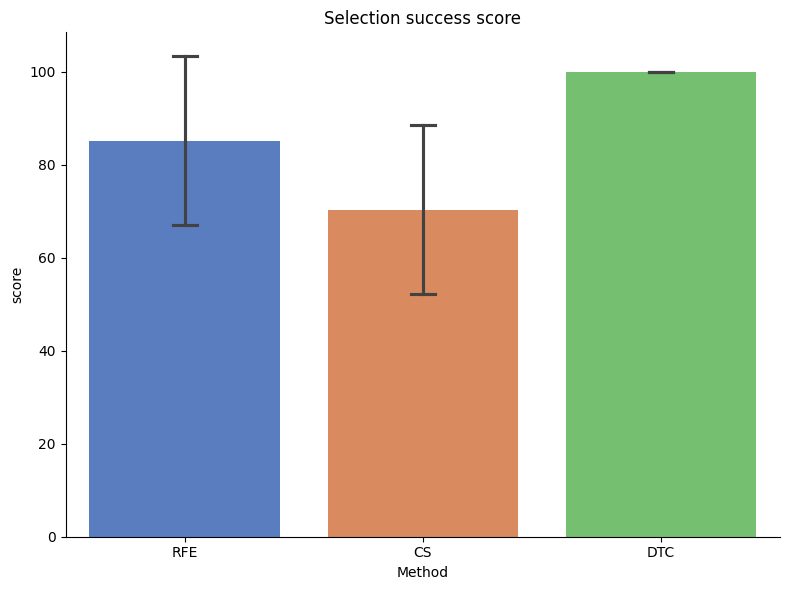

In [36]:
plot_barplot(s_df_melted, metric = "score")